# PIK3CA: Effects of Mutation on IRS2

<b> Standard imports for playing with and plotting data frames. </b>

In [21]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

<b> Import CPTAC data </b>

In [22]:
import CPTAC

In [23]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

# PI3KCA mutation and IRS1 proteome abundance 

### Perform a t-test with mutated and non-mutated protein levels

In [24]:
protList = ['IRS2']
pcutoff = 0.05 / len(protList)
gene = 'PIK3CA'

proteomics = proteomics[:100]

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 

 ### We can now plot the data 

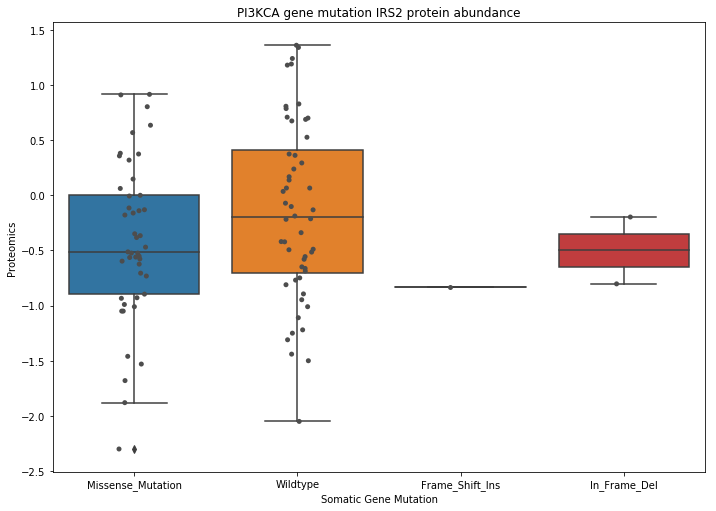

In [25]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y=protein, ax = ax)
somatic_boxplot.set_title("PI3KCA gene mutation IRS2 protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y=protein,jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

# PI3KCA mutation and IRS1 phosphoproteome abundance 

In [26]:
sites = phos.columns
p_values = []
site_names = []
protein = 'IRS2'


pattern = re.compile(protein)
isInList = filter(pattern.search, sites)
if next(isInList, None) is not None:
    phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
    phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
    for site in phosphositesdf.columns:
        if (site is not 'Mutation'):
            sitedf = CPTAC.compare_mutations(phos, site, gene)
            mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
            wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
            ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
            p_values.append(ttest[1])
            site_names.append(site)     
                
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

['IRS2-S1100' 'IRS2-S1174' 'IRS2-S391' 'IRS2-S560' 'IRS2-S577' 'IRS2-S643'
 'IRS2-S731' 'IRS2-S736' 'IRS2-S973' 'IRS2-T520']
[0.00036839 0.03698679 0.00064881 0.00194125 0.00552392 0.03895987
 0.0099314  0.00212755 0.02244557 0.02244557]
{'IRS2-S1100': 0.00036838974061340047, 'IRS2-S1174': 0.03698679389213176, 'IRS2-S391': 0.0006488051530427299, 'IRS2-S560': 0.0019412522741409284, 'IRS2-S577': 0.005523922057285959, 'IRS2-S643': 0.03895987410918943, 'IRS2-S731': 0.009931402585666363, 'IRS2-S736': 0.0021275507819803925, 'IRS2-S973': 0.022445568004119638, 'IRS2-T520': 0.022445568004119638}


In [27]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)

phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor']

## Plot all of the phosphoproteomic measurements

In [28]:
protein = 'IRS2'
gene = 'PIK3CA'
phosdf = CPTAC.compare_mutations(phos, protein, gene)
#print(phosdf)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [29]:
phosdf.loc[(phosdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
phosdf.loc[(phosdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

phosdf = pd.melt(phosdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
phosdf = phosdf.loc[(phosdf["Mutation"] == "Control") | (phosdf["Mutation"] == "Mutated")]
phosdf = phosdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)
#phosdf = phosdf.loc[(phosdf['Type'] == significant_sites)]
plotdf = None

In [30]:
interested_sites = ['IRS2-S391', 'IRS2-S577', 'IRS2-S643', 'IRS2-T520']
for site in interested_sites:
    tempdf = phosdf.loc[(phosdf['Type'] == site)]
    print(tempdf)
    if plotdf is None:
        plotdf = tempdf
    else:
        plotdf = plotdf.append(tempdf)
        
print(plotdf)

     Mutation       Type  Reading
1867  Mutated  IRS2-S391 -2.10000
1885  Mutated  IRS2-S391 -0.62600
1883  Mutated  IRS2-S391 -0.35450
1880  Mutated  IRS2-S391 -0.95800
1876  Mutated  IRS2-S391 -1.06700
1874  Mutated  IRS2-S391 -0.11000
1873  Mutated  IRS2-S391 -0.10000
1865  Mutated  IRS2-S391 -0.83400
1864  Mutated  IRS2-S391  0.30900
1863  Mutated  IRS2-S391  0.26600
1860  Mutated  IRS2-S391 -0.86100
1859  Mutated  IRS2-S391 -0.30500
1842  Mutated  IRS2-S391 -0.60200
1839  Mutated  IRS2-S391  0.07480
1887  Mutated  IRS2-S391 -0.51900
1888  Mutated  IRS2-S391 -0.37600
1889  Mutated  IRS2-S391  0.00000
1891  Mutated  IRS2-S391 -0.24400
1894  Mutated  IRS2-S391 -1.78000
1895  Mutated  IRS2-S391  0.43350
1896  Mutated  IRS2-S391 -0.00207
1897  Mutated  IRS2-S391 -0.91400
1898  Mutated  IRS2-S391 -0.74500
1832  Mutated  IRS2-S391 -0.06095
1837  Mutated  IRS2-S391 -0.21800
1830  Mutated  IRS2-S391 -0.36500
1811  Mutated  IRS2-S391 -0.43400
1802  Mutated  IRS2-S391  0.39400
1808  Mutated 

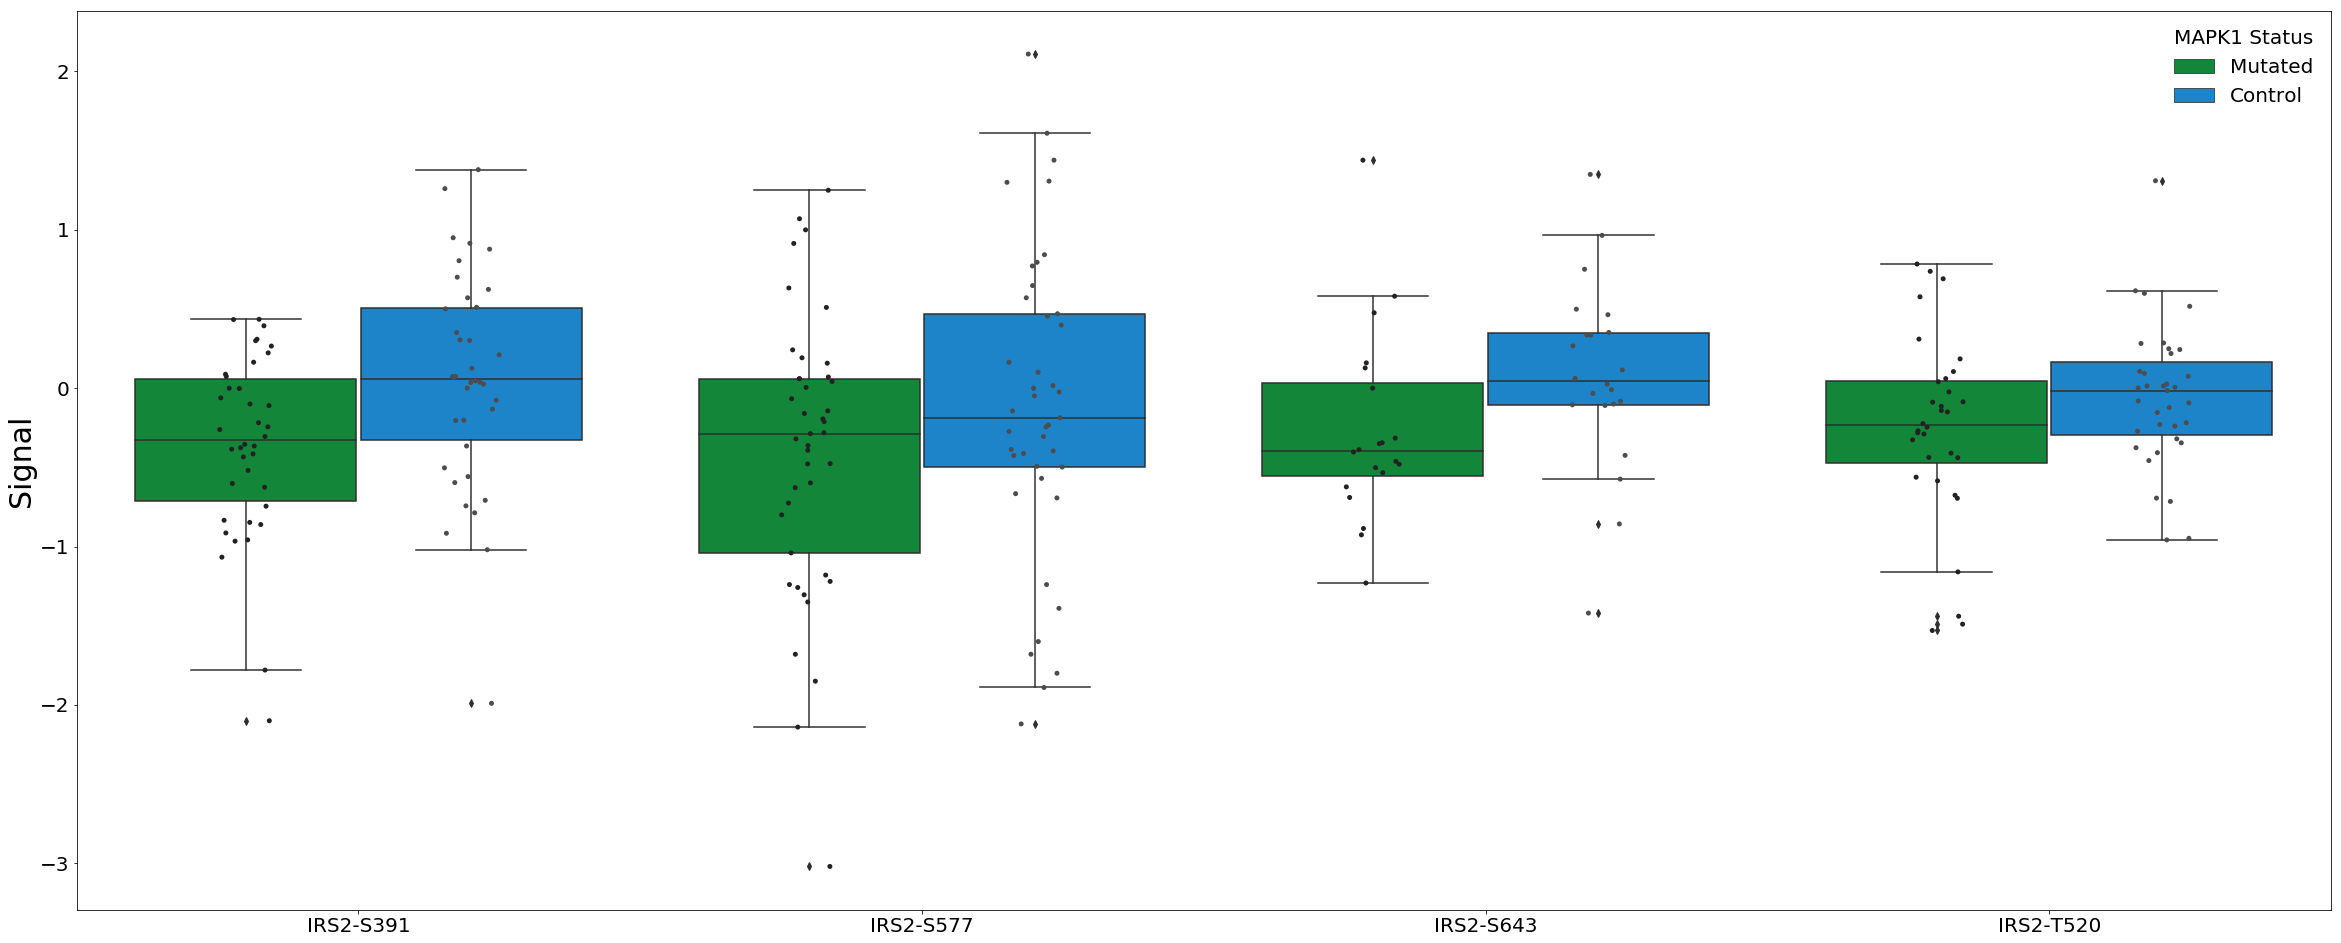

In [31]:
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='MAPK1 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
plt.show()

In [32]:
plotdf = None
#interested_sites = ['IRS2-S391', 'IRS2-S577', 'IRS2-S643', 'IRS2-T520']
for site in significant_sites:
    tempdf = phosdf.loc[(phosdf['Type'] == site)]
    print(tempdf)
    if plotdf is None:
        plotdf = tempdf
    else:
        plotdf = plotdf.append(tempdf)
        
print(plotdf)

   Mutation        Type  Reading
0   Mutated  IRS2-S1100 -1.00000
69  Mutated  IRS2-S1100 -2.37000
85  Mutated  IRS2-S1100 -1.39000
91  Mutated  IRS2-S1100  0.43700
89  Mutated  IRS2-S1100 -0.34000
88  Mutated  IRS2-S1100 -0.94000
87  Mutated  IRS2-S1100 -2.12000
83  Mutated  IRS2-S1100 -0.11000
80  Mutated  IRS2-S1100 -1.98000
76  Mutated  IRS2-S1100 -1.03000
74  Mutated  IRS2-S1100 -1.02000
73  Mutated  IRS2-S1100 -0.53700
94  Mutated  IRS2-S1100 -0.08590
95  Mutated  IRS2-S1100  0.87700
98  Mutated  IRS2-S1100 -2.25000
97  Mutated  IRS2-S1100  1.16000
96  Mutated  IRS2-S1100  1.30000
20  Mutated  IRS2-S1100 -0.45500
22  Mutated  IRS2-S1100 -0.99100
21  Mutated  IRS2-S1100 -0.63300
52  Mutated  IRS2-S1100 -2.08000
54  Mutated  IRS2-S1100 -0.09450
17  Mutated  IRS2-S1100 -0.38800
13  Mutated  IRS2-S1100  1.22000
59  Mutated  IRS2-S1100 -0.00399
60  Mutated  IRS2-S1100 -2.40000
62  Mutated  IRS2-S1100 -1.37000
63  Mutated  IRS2-S1100 -0.49600
64  Mutated  IRS2-S1100 -1.34000
11  Mutate

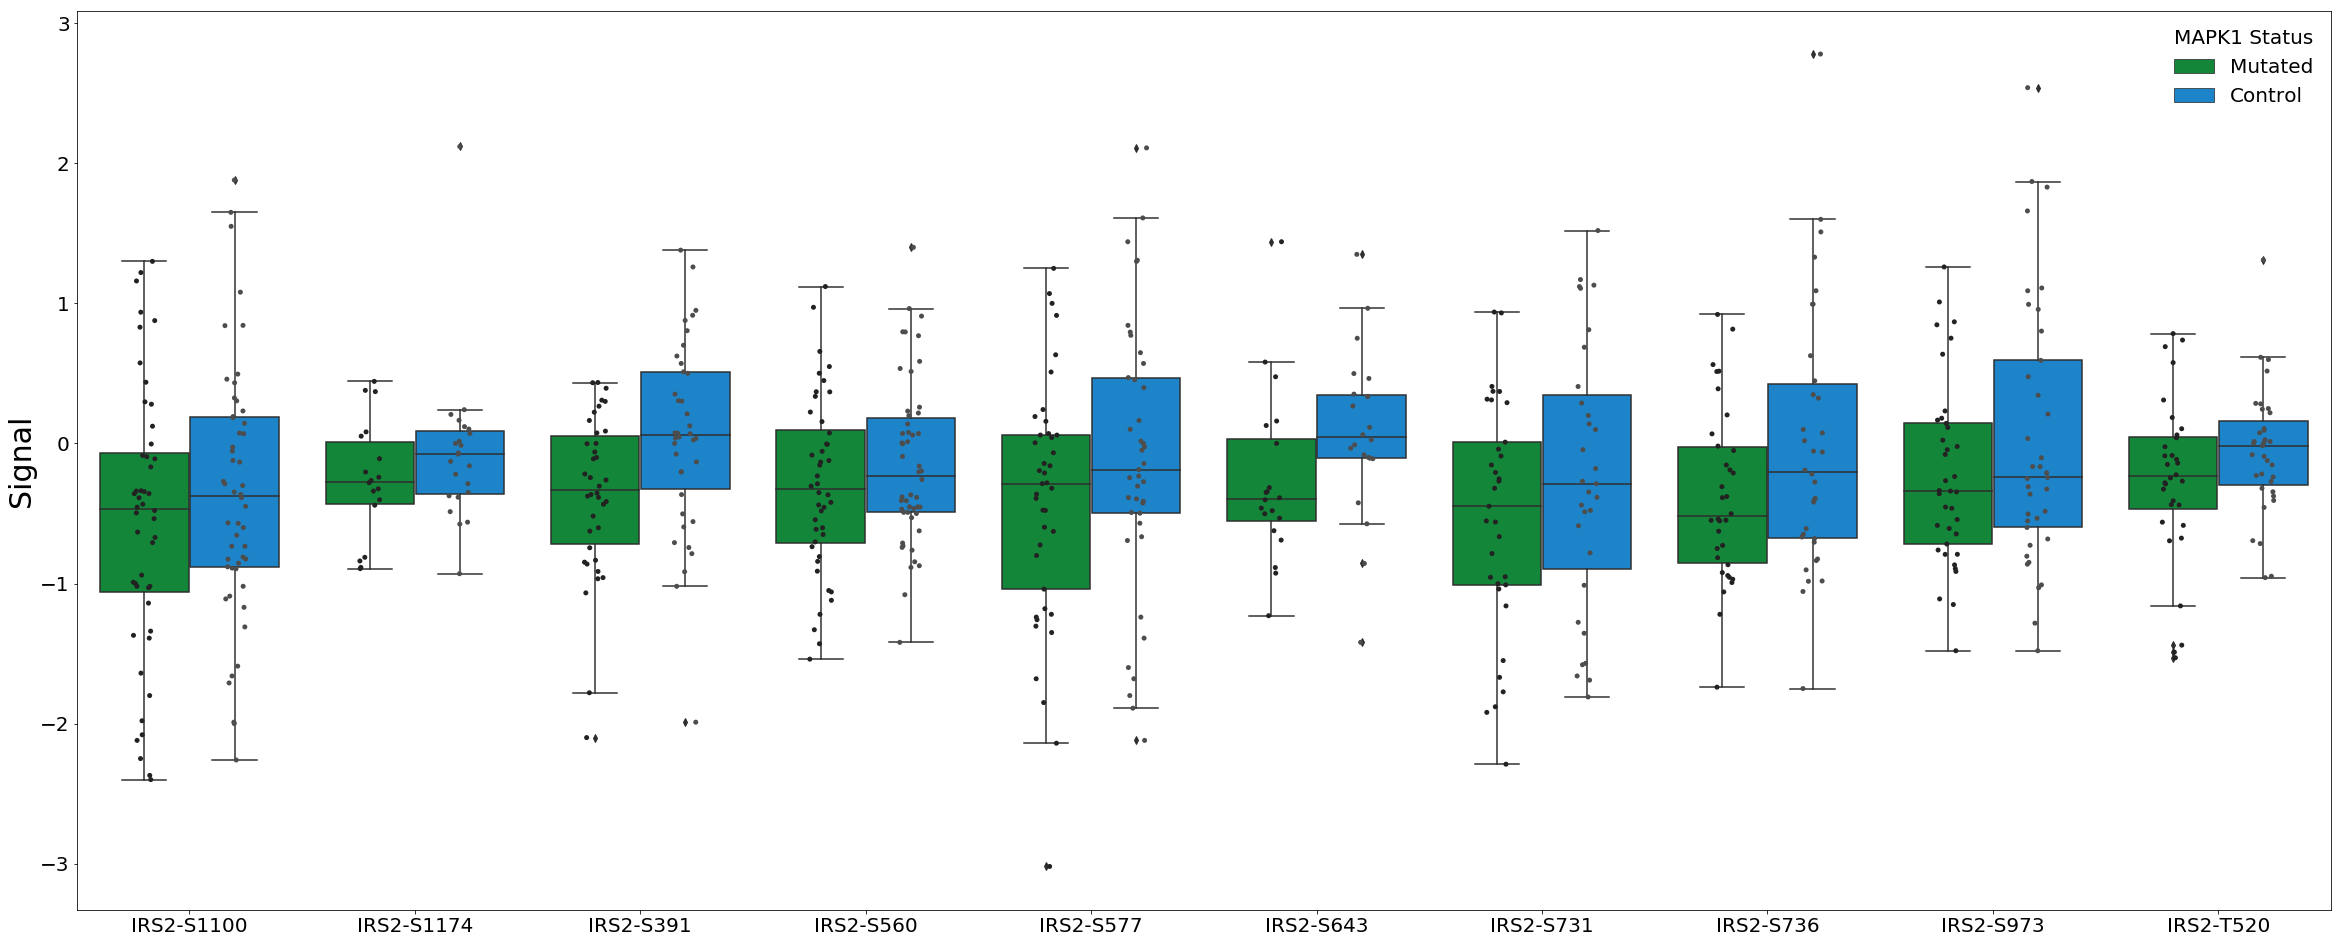

In [33]:
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='MAPK1 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
plt.show()